# Homework 3
## IDS 576 <br>
Name: Isaac Salvador <br>
Email: isalva2@uic.edu <br>
UIN: 6669845132 <br>

Name: Ahreum Kim <br>
Email: akim239@uic.edu <br>
UIN: 653241895 <br>

Name: Sadjad Bazarnovi <br>
Email: sbazar3@uic.edu <br>
UIN: 679314994 <br>

# 1. RNN for Language Modeling

## `torchtext` IMDB dataset
We begin by setting up the `torch` environment and downloading the `IMDB` dataset from the `torchtext.data.Dataset` class. The `torchtext` dataset is preprocessed into a into a collection of lists of tokens.

In [2]:
import torch
from torch import mps

import torchtext
from torchtext import datasets

from nltk.tokenize import word_tokenize
import re

# make torch deterministic for reproducibility
seed = 576
torch.manual_seed(seed)

# set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Torch Device:", device)

Torch Device: mps


In [3]:
# train model on training split
train_iter = datasets.IMDB(split="train")

# initialize a list to store reviews
reviews = []

# append each review
for _, review in train_iter:
    reviews.append(review)

# initialize list to store tokenized reviews
tokenized_reviews = []

# preprocess and tokenize reviews
for review in reviews:
    lowercase_review = review.lower()
    cleaned_review = re.sub(r'[^A-Za-z0-9\s]+', '', lowercase_review.replace('<br />', ' '))
    tokenized_reviews.append(word_tokenize(cleaned_review))

## Markov (n-gram) Language Model

A _Markov (n-gram)_ language model is a purely statistical character-level model. The model is based on the assumption that the probability of the next word in a sequence is based on the history _h_ of the preceding words in the sequence. For a set number _n_ of immediately previous words (or tokens) in the sequence, this assumption can be expressed as:

$$P(w|h)\approx P(w_n|w_{1:n-1})$$

A _bigram_ is specific _n-gram_ case (_n_ = 2) where the conditional probability of the next word in a sequence is dependent solely on the preceding word in the sequence

$$P(w|h)\approx P(w_n|w_{n-1})$$

We can further generalize this propoerty to _trigrams_ (_n_ = 3) such that the conditional probability of the next word in a sequence is

$$P(w|h)\approx P(w_n|w_{n-2, n-1})$$

Let us create a general python class `build_random_ngram_model` that replicates the above funtionality with the IMBD dataset. In order to reduce recursive, repeating predicitons, the `predic()` method introduces randomness to the model, using a weighted choice between all tokens $w_n$ that correspond to a certain context $w_{1:n-1}$. The method parameter `rand` allows us to select the top `rand` weighted words from the model.

In [4]:
from nltk.util import ngrams
from tqdm import tqdm
import random

class build_random_ngram_model():

    '''
    This class builds a Markov (n-gram) language model.
    '''
    def __init__(self, tokenized_reviews: list, n: int = 2):
        self.n = n
        self.model = self._build_model(tokenized_reviews, n=n)

    def _build_model(self, tokenized_reviews, n):

        # empty return model
        model = {}

        # build model
        print("builing model...")
        for review in tqdm(tokenized_reviews):

            # build n-grams from reviews
            for ngram in ngrams(review, n, pad_right=True, pad_left=True):
                context = tuple(ngram[:-1])
                target = ngram[-1]

                # check if context is already in the model
                if context not in model:
                    model[context] = {}

                # get frequency counts of co-occurrence
                if target not in model[context]:
                    model[context][target] = 1
                else:
                    model[context][target] += 1

        # convert frequency counts to probabilities
        for context in model:
            count = float(sum(model[context].values()))
            for target in model[context]:
                model[context][target] /= count

        # return trained model
        print("done!")
        return model

    def get_model(self) -> dict:

        '''
        Returns model stored as dict.
        '''

        return self.model

    def predict(self, words: str, rand: int = None) -> str:

        '''
        This function returns the next word given the input string.
        Randomly select out of the top rand probabilities given a certain context.
        '''

        # get last n-1 words in string
        key = tuple(words.split())[1-self.n:]

        # get top keys in dictionary
        top_keys = sorted(self.model[key], key = self.model[key].get, reverse=True)[:rand]

        # get probs of top keys
        top_values = [self.model[key][top_key] for top_key in top_keys]

        # select random key
        selected_key = random.choices(top_keys, weights = top_values, k=1)[0]

        return selected_key

    def complete(self, words: str, rand: int = None) -> str:

        '''
        This function returns the entire string with the predicted next word
        '''

        next_word = self.predict(words, rand = rand)

        # if context does not exist in model dict return original words
        if next_word is not None:
            completed_string = words+" "+next_word
        else:
            completed_string = words

        return completed_string

    def review(self, words: str, l = 10, rand: int = None) -> str:

        '''
        This function completes a review for an additional l words.
        '''

        working_words = words

        i = 0

        while i < l:
            working_words = self.complete(working_words, rand = rand)
            i += 1

        return working_words

We can now build a trigram language model and generate random reviews from the input string `My favorite movie`.

In [5]:
trigram_model = build_random_ngram_model(tokenized_reviews, 3)

for i in range(5):
    generated_text = trigram_model.review("My favorite movie", 17)
    print(f"Review {i+1}: {generated_text}")

builing model...


100%|██████████| 25000/25000 [00:04<00:00, 6164.88it/s]


done!
Review 1: My favorite movie dawn of the plot is really a new exciting universe represents the cornerstone of the steam the
Review 2: My favorite movie but in an oscar nomination has a choice he has no memory of david jason the mike
Review 3: My favorite movie i saw first the action switches to a tearstained reunion with his role yet i am now
Review 4: My favorite movie role has the same verve as characters go through the chest all made stuff like what remained
Review 5: My favorite movie this movie seems like hes treading on well i researched the plot since others have felt isolated


## LSTM Based Language Model

For the LSTM based language model we shall be following along with [Seq2Seq_LSTM_Simple_Sentiment_Analysis.ipynb](https://github.com/thejat/dl-notebooks/blob/master/examples/rnn/Seq2Seq_LSTM_Simple_Sentiment_Analysis.ipynb) and making modifications as neccessary.

First we download the `"train"` and `"test"` splits from the `IMDB` dataset and check the size of each split. For the sake of computational complexity, the training dataset is reduced to 2,000 instance and the validation dataset is reduced to 200.

In [8]:
from torch.utils.data import Subset

train_n = 2000
valid_n = 200

train_dataset_raw = datasets.IMDB(split="train")
valid_dataset_raw = datasets.IMDB(split="test")

train_dataset = Subset(list(train_dataset_raw), range(train_n))
valid_dataset = Subset(list(valid_dataset_raw), range(valid_n))

print("Train dataset size: ",len(list(train_dataset)))
print("Test dataset size: ",len(list(valid_dataset)))

Train dataset size:  2000
Test dataset size:  200


### Data Preprocessing Pipeline
We next construct utilities to aid in the preprocessing of the `IMDB` dataset. Since we are creating a language model, our preprocessing pipeline must result in the generation of an _input sequence_ and _target sequence_. The _input sequence_ and _target sequence_ differ only by one "time-step".

$$X_{Raw} =[x_1, x_2, \ldots, x_T]$$
$$X_{Input} = [x_1, x_2, \ldots, x_{T-1}]$$
$$X_{Target} = [x_2, x_3, \ldots, x_{T}]$$

The first utility is the `tokenizer()`, that parses through string instances in the datasets and converts to tokens.

In [9]:
def tokenizer(text):
    # step 1. remove HTML tags. they are not helpful in understanding the sentiments of a review
    # step 2: use lowercase for all text to keep symmetry
    # step 3: extract emoticons. keep them as they are important sentiment signals
    # step 4: remove punctuation marks
    # step 5: put back emoticons
    # step 6: generate word tokens
    text = re.sub("<[^>]*>", "", text)
    text = text.lower()
    emoticons = re.findall("(?::|;|=)(?:-)?(?:\)|\(|D|P)", text)
    text = re.sub("[\W]+", " ", text)
    text = text + " ".join(emoticons).replace("-", "")
    tokenized = text.split()
    return tokenized

We next create a utility to obtain `token_counts` from the dataset.

In [10]:
from collections import Counter

token_counts = Counter()

for _, line in iter(train_dataset):
    tokens = tokenizer(line)
    token_counts.update(tokens)

print('IMDB train dataset vocab size:', len(token_counts))

IMDB train dataset vocab size: 23330


The tokens are then sorted by frequency and converted to to integers using the `vocab` object. For the sake of computational complexity the first 1,000 words of the ordered dictionary by freqeuency are used for the model vocabulary.

In [11]:
from collections import OrderedDict
from torchtext.vocab import vocab

sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

reduced_ordered_dict = OrderedDict()

count = 0
for key, value in ordered_dict.items():
    reduced_ordered_dict[key] = value
    count += 1

    if count == 1000:
        break

vb = vocab(reduced_ordered_dict)

vb.insert_token("<pad>", 0)  # special token for padding
vb.insert_token("<unk>", 1)  # special token for unknown words
vb.set_default_index(1)

# print some token indexes from vocab
for token in ["this", "is", "an", "example"]:
    print(token, " --> ", vb[token])

this  -->  11
is  -->  7
an  -->  37
example  -->  407


In [12]:
input_pipeline = lambda x: [vb[token] for token in tokenizer(x)][:-1]
target_pipline = lambda x: [vb[token] for token in tokenizer(x)][1:]

length = 5
print("Example Sequences")
for i in list(train_dataset_raw)[:4]:
    example_tokens = tokenizer(i[1])[:length+1]
    example_input = input_pipeline(i[1])[:length]
    example_target = target_pipline(i[1])[:length]

    print(f'Sample Tokens: {example_tokens}')
    print(f'Input Sequence: {example_input}')
    print(f'Target Sequence: {example_target}', "\n")

Example Sequences
Sample Tokens: ['i', 'rented', 'i', 'am', 'curious', 'yellow']
Input Sequence: [9, 1, 9, 257, 1]
Target Sequence: [1, 9, 257, 1, 1] 

Sample Tokens: ['i', 'am', 'curious', 'yellow', 'is', 'a']
Input Sequence: [9, 257, 1, 1, 7]
Target Sequence: [257, 1, 1, 7, 3] 

Sample Tokens: ['if', 'only', 'to', 'avoid', 'making', 'this']
Input Sequence: [44, 57, 6, 474, 202]
Target Sequence: [57, 6, 474, 202, 11] 

Sample Tokens: ['this', 'film', 'was', 'probably', 'inspired', 'by']
Input Sequence: [11, 21, 14, 242, 1]
Target Sequence: [21, 14, 242, 1, 36] 



The preprocessing utilities will be applied at the batch level, as a `collate_fn` argument. The source code is modified to return the input and target sequences. Since these sequences are of the same length, we do not need to return length

In [13]:
import torch.nn as nn

def collate_batch(batch):
    input_list, target_list, = [], []

    # iterate over all reviews in a batch
    for _, _text in batch:

        # input preprocessing
        processed_input = torch.tensor(input_pipeline(_text), dtype=torch.int64)

        # target preprocessing
        processed_target = torch.tensor(input_pipeline(_text), dtype=torch.int64)


        # store the processed text in input and target lists
        input_list.append(processed_input)
        target_list.append(processed_target)

    # pad the processed reviews to make their lengths consistant
    padded_input_list = nn.utils.rnn.pad_sequence(
        input_list, batch_first=True)

    padded_target_list = nn.utils.rnn.pad_sequence(
        target_list, batch_first=True
    )

    # return
    # 1. a list of processed and padded input texts
    # 2. a list of processed and padded target texts
    # 3. a list of review text original lengths (before padding)
    return padded_input_list.to(device), padded_target_list.to(device)

### Batching the Training, Validation, and Test Datasets
The `IMDB` Datasets are loaded into torch `DataLoader()` objects with the above `collate_batch()` function.

In [14]:
from torch.utils.data import DataLoader
batch_size = 32

train_dl = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch
)
valid_dl = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

We will now modify the source code's sentiment analysis `RNN` class for the purposes of language modeling. An overview of the architecture and design choices made to implement this are as follows:
- An **Embedding layer** as as explained by the source code.
- An **LSTM layer**  to capture long range dependencies and relationships in the text.
- A **Fully Connected layer** to obtain `logits`, the raw unnormalized predictions for each token at each "time step" in the model.

In [16]:
# create langauge model class
class RNN_Language(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.LSTM(embed_dim, vocab_size)#, batch_first=True)

    def forward(self, input_sequence):
        out = self.embedding(input_sequence)
        out, _ = self.rnn(out)
        out.view(-1, vocab_size)
        return out

# instantiate a model
vocab_size = len(vb)
embed_dim = 20

torch.manual_seed(576)
model = RNN_Language(vocab_size, embed_dim)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 4124232


### Loss Function, Optimizer and Training Loop

We will utilize `CrossEntropyLoss()` as our loss function and the `Adam()` algorithm for optimization.

In [17]:
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

model.to(device)

num_epochs = 10

# training loop

def train(model, train_dl, valid_dl):

    train_history, valid_history = [], []

    for epoch in range(num_epochs):

        print(f"Epopch: {epoch}")

        model.train()
        total_loss, valid_loss = 0, 0

        # training
        for input_batch, target_batch in tqdm(train_dl):
            with torch.set_grad_enabled(True):
                # forward pass
                optimizer.zero_grad()
                logits = model(input_batch)
                loss = criterion(logits.view(-1, vocab_size), target_batch.view(-1))

                # backwards pass
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * batch_size

        avg_loss = total_loss / len(train_dl.dataset)
        train_history.append(avg_loss)
        print(f"Training loss:\t{avg_loss}")

        # validation
        for input_batch, target_batch in valid_dl:
            with torch.no_grad():
                logits = model(input_batch)
                loss = criterion(logits.view(-1, vocab_size), target_batch.view(-1))

            valid_loss += loss.item() * batch_size

        avg_valid_loss = valid_loss / len(valid_dl.dataset)
        valid_history.append(avg_valid_loss)
        print(f"Validation Loss\t{avg_valid_loss}\n")


    return train_history, valid_history

In [18]:
train_history, valid_history = train(model, train_dl, valid_dl)

Epopch: 0


100%|██████████| 63/63 [00:19<00:00,  3.22it/s]


Training loss:	5.988236808776856
Validation Loss	6.549685287475586

Epopch: 1


100%|██████████| 63/63 [00:18<00:00,  3.48it/s]


Training loss:	5.810271705627441
Validation Loss	6.481771621704102

Epopch: 2


100%|██████████| 63/63 [00:18<00:00,  3.41it/s]


Training loss:	5.758795715332031
Validation Loss	6.4237628936767575

Epopch: 3


100%|██████████| 63/63 [00:18<00:00,  3.39it/s]


Training loss:	5.714550354003906
Validation Loss	6.379196243286133

Epopch: 4


100%|██████████| 63/63 [00:18<00:00,  3.47it/s]


Training loss:	5.679977897644043
Validation Loss	6.3318408203125

Epopch: 5


100%|██████████| 63/63 [00:18<00:00,  3.44it/s]


Training loss:	5.647700401306152
Validation Loss	6.286894607543945

Epopch: 6


100%|██████████| 63/63 [00:18<00:00,  3.46it/s]


Training loss:	5.602602851867676
Validation Loss	6.245165328979493

Epopch: 7


100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Training loss:	5.576066429138184
Validation Loss	6.225190963745117

Epopch: 8


100%|██████████| 63/63 [00:18<00:00,  3.47it/s]


Training loss:	5.552427825927734
Validation Loss	6.203888931274414

Epopch: 9


100%|██████████| 63/63 [00:18<00:00,  3.43it/s]


Training loss:	5.531216690063476
Validation Loss	6.18452407836914



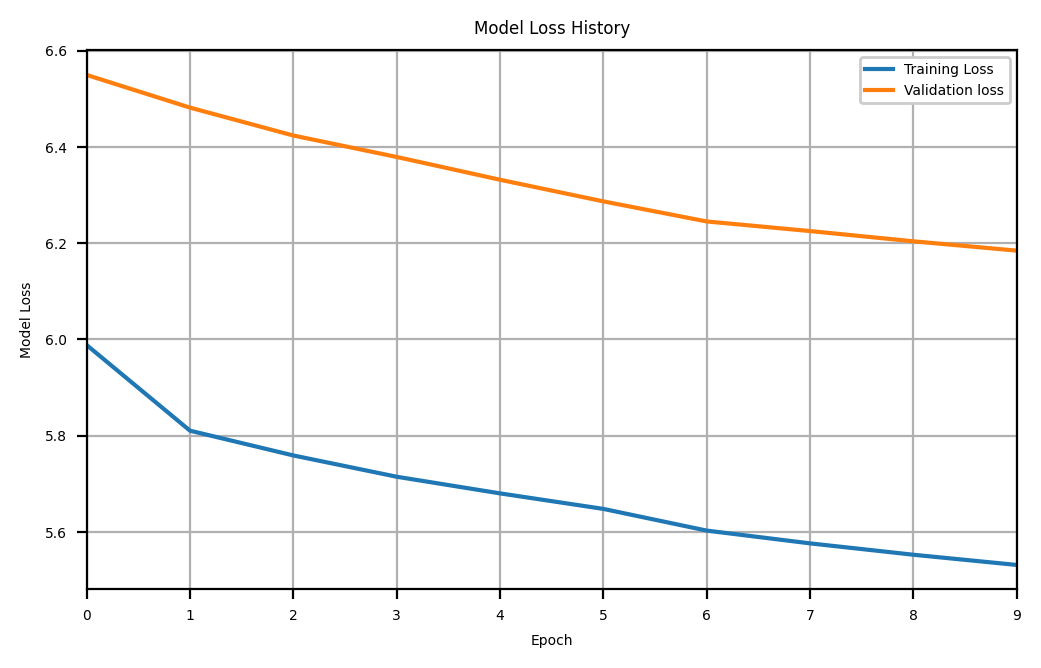

In [87]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 5})


# plot loss history
fig, ax = plt.subplots(figsize=(6,3.5), dpi=200)

ax.plot(
        train_history,
        label = r'Training Loss',
        #marker = 'o',
        markersize = 4)

ax.plot(
        valid_history,
        label = r'Validation loss',
        #marker = 'o',
        markersize = 4)

ax.set_title("Model Loss History")
ax.set_xlabel('Epoch')
ax.set_ylabel('Model Loss')
ax.set_xlim(0, len(train_history)-1)
ax.legend()
ax.legend().get_frame().set_alpha(1.0)

ax.grid(True)

### Training and Evaluation Pipelines

In [22]:
import torch.nn.functional as F

def generate_text(model, text, max = 17, adjust = 1):
    # set model to evaluation
    model.eval()

    # copy input string
    input = text

    # iterate max times
    for _ in range(max):

        # convert to tensor tokens
        text_tokens = [vb[token] for token in tokenizer(input)]
        tensor_tokens = torch.tensor(text_tokens, dtype = torch.int64).to(device)

        # evaluate on model and adjust by scalar to add addtional randomness
        with torch.no_grad():
            logits = model(tensor_tokens)[-1,:] / adjust

        # convert to probabilies
        probs = F.softmax(logits, dim=-1)

        # use multinomial distribution to select index of next word based on probs
        choice = torch.multinomial(probs, 1).item()

        # obtain next word from vb
        next_word = vb.lookup_token(choice)

        # append to end of input string
        input = input+" "+next_word

    return input

for i in range(5):
    generated_text = generate_text(model, "My favorite movie", 17, 10)
    print(f"Review {i+1}: {generated_text}")

Review 1: My favorite movie answer part pretty names times bottom today lady right across a scary working finds exactly down first
Review 2: My favorite movie weird special town hard vampire german cheesy heard difficult looking non age people trash simply own etc
Review 3: My favorite movie 20 paid important example movies rest t exactly goes nowhere very certain themselves finally sex any feel
Review 4: My favorite movie leaves they best predictable game premise dramatic different project lead cheesy dumb disappointing people f cast quite
Review 5: My favorite movie just kill actress actor idea score bought air re freeman zombie casting killed lady non simple heart


# 2. Sequence to Sequence Model for Translation
To begin our translation task for English to Korean and vice versa, we will again follow along with [Seq2Seq_LSTM_Simple_Sentiment_Analysis.ipynb](https://github.com/thejat/dl-notebooks/blob/master/examples/rnn/Seq2Seq_LSTM_Simple_Sentiment_Analysis.ipynb). The first step is to process `kor.txt` and convert using a custom torch `Dataset` class.

In [74]:
from torch.utils.data import Dataset

class Translation_Dataset(Dataset):
    '''
    Creates a torch englsh-korean translation dataset.
    '''
    
    def __init__(self, file: str, reverse: bool = False):
        self.data = self._getdata(file, reverse)

    def _getdata(self, file, reverse):
        '''
        Internal method to return english-korean translation pairs.
        '''
        
        # read txt file
        txt_raw = open(file, "r")
        
        # write to string
        txt_data = txt_raw.read()
        
        # split on newline char
        txt_list = txt_data.split("\n")
        
        # split on tab char and create tuples of english-korean, reverse as needed
        split_list = [x.split("\t") for x in txt_list]
        
        tuple_list = [x[0:2] for x in split_list]
        if reverse == True:
            tuple_list = [x[::-1] for x in tuple_list]
        
        return tuple_list
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        phrase, translation = self.data[idx]
        return phrase, translation

In [82]:
file = "Misc_files/data/kor.txt"

eng_kor_dataset = Translation_Dataset(file)
kor_eng_dataset = Translation_Dataset(file, reverse=True)